In [54]:
### load csv
import pandas as pd
import numpy as np
import re

file_name='HNDB_Progress_Notes_clean.csv'

data=pd.read_csv(file_name,index_col='date_of_service_dttm',parse_dates=True,error_bad_lines=False)

cols=['mrn','note_id','ip_note_type','author_service','note_narr']
data=data[cols]
data=data.dropna(subset=['mrn','note_narr'])

#data=data[(data['author_service']=='RADIATION THERAPY') | (data['author_service']=='RADIATION ONCOLOGY')]
print (data.shape[0])

72695


In [55]:
import re
def getTNM(para):
    '''gets TNM stage of tumor from input string'''
    pattern=r'[cpyr]?([Tt]\d\-)?[Tt][\dxX](\w)?( )?([Nn]\d\-)?[Nn][\dxX]?(\w)?( )?[Mm]?(\d|[Xx])?'
    search=re.search(pattern,para)
    stage=np.nan
    if search:
        stage=search.group()
    return stage
def getStage(para):
    pattern=r'Stage [Ii]\w+'
    try:
        search=re.search(pattern,para)
        if search:
            return search.group()
        else:
            return np.nan
    except:
        return np.nan

data['TNM']=data['note_narr'].apply(getTNM)
data['Stage']=data['note_narr'].apply(getStage)

print(data.Stage.value_counts())
print(data.TNM.value_counts())

Stage IV      762
Stage IVA     529
Stage IVa     224
Stage III     189
Stage II      181
Stage IVb      39
Stage IVB      36
Stage IIIB     12
Stage IIIC     12
Stage IA       10
Stage IA3      10
Stage IIA       9
Stage IIB       8
Stage IIIA      5
Stage IIIb      4
Stage IVC       3
Stage IIIa      1
Name: Stage, dtype: int64
T2N2b      1571
T1N2b      1118
T3N0       1115
T3N2b      1100
T4N0        853
           ... 
T4a N0        1
T4bN2M0       1
cT1N0MX       1
cT2pN0        1
T1bN1M0       1
Name: TNM, Length: 842, dtype: int64


In [68]:
### add staging
import matplotlib.pyplot as plt

df=data

### define functions to get T value, N value, M value
def getT(stage):
    '''gets the value for T from stage'''
    try:
        toReturn=stage.upper().split('N')[0]
        if toReturn[0] !='T':
            toReturn=toReturn[1:]    
        toReturn=toReturn[1:].strip()
        return toReturn
    except:
        return np.nan
def getN(stage):
    '''gets value for N from stage'''
    try:
        toReturn=stage.upper().split('M')[0]
        toReturn=toReturn.split('N')[1].strip()
        return toReturn
    except:
        return np.nan

def getM(stage,sent):
    '''gets values for M from stage, assumes no mention of M is the same as M0'''
    try:
        if hasMetsLanguage(sent):
            return '1'
        elif 'M' not in stage:
            return '0'
        else:
            toReturn=stage.upper().split('M')[1].strip()
            return toReturn
    except:
        return np.nan

df['T']=df.TNM.apply(getT)
df['N']=df.TNM.apply(getN)

Ms=[]
for index,row in df.iterrows():
    stage=row['TNM']
    sent=row['note_narr']
    Ms.append(getM(stage,sent))
df['M']=Ms

def hasNegativeLanguage(sentence):
    '''check if a sentence expresses negative language'''
    pattern=r'[Nn]o|[Nn][Ee][Dd]|[Ww]ithout|does not have|[Ss]uspicious|Metastatic Sites NA|concerned about|negative|lack of|(likely|may) represent'
    search=re.search(pattern,sentence)
    flag=False
    if search:
        flag=True
    return flag
def hasMetsLanguage(sentence):
    '''check if a sentence indicates a recurrent tumor or metastasis'''
    flag=False
    search=re.search(r'[Mm]et(s|astatic|astas[ie]s) ',sentence)
    if search and not hasNegativeLanguage(sentence):
        flag=True
    return flag
            
def get_Cancer_Stage(T,N,M):
    '''get stage of disease from TNM inputs, using AJCC 7th criteria'''
    stage=np.nan
    if str(M)=='1':
        stage='IVc'
    elif len(str(T))==0 and len(str(N))==0:
        stage=''
    elif str(T)=='1' and str(N)=='0':
        stage='I'
    elif str(T)=='2' and str(N)=='0':
        stage='II'
    elif (str(T)=='3' and str(N)<='1') or (str(T)<='2' and str(N)=='1'):
        stage='III'
    elif ((str(T)=='4' or str(T)=='4A') and (str(N)<='2C')) or (str(T)>='1' and str(T)<'4' and str(N)>='2' and str(N)<='2C'):
        stage='IVa'
    elif str(T)=='4B' or (str(N)>='3' and str(N)<'8'):
        stage='IVb'
    else:
        stage=np.nan
    return stage

cancer_stages=[]
for index,row in df.iterrows():
    T=row['T']
    N=row['N']
    M=row['M']
    cancer_stages.append(get_Cancer_Stage(T,N,M))
df['Stage_']=cancer_stages

print (df['Stage_'].value_counts().plot(kind='bar'))

KeyboardInterrupt: 

In [57]:
import math
### fill in stage if TNM stage not available
stages_=[]
for index,row in df.iterrows():
    stage=row['Stage']
    stage_=row['Stage_']
    try:
        if math.isnan(stage_):
            stages_.append(stage)
        else:
            stages_.append(stage_)
    except:
        stages_.append(stage_)
df['Stage_']=stages_

### get stage
df=df.sort_index()
mrns=df.mrn.unique()
ptx_info=[]
for mrn in mrns:
    sub_df=df[df['mrn']==mrn]
    ptx_info.append(sub_df)
data_stage=[]
for index,ptx in enumerate(ptx_info):
    ptx_info[index]=ptx_info[index].dropna(subset=['Stage_'])
    try:
        data_stage.append([ptx_info[index].iloc[0]['mrn'],ptx_info[index].iloc[-1]['Stage_']])
    except:
        a=0
    
### get TNM Data    
df=df.sort_index()
mrns=df.mrn.unique()
ptx_info=[]
for mrn in mrns:
    sub_df=df[df['mrn']==mrn]
    ptx_info.append(sub_df)
data_TNM=[]
for index,ptx in enumerate(ptx_info):
    ptx_info[index]=ptx_info[index].dropna(subset=['TNM'])
    try:
        data_TNM.append([ptx_info[index].iloc[0]['mrn'],ptx_info[index].iloc[-1]['TNM']])
    except:
        a=0


size of stage df: 1155
size of tnm df: 1228
size of merged df: 1259
IVA    659
III    193
II     101
IVB     71
I       67
IVC     34
IV      30
Name: Stage, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


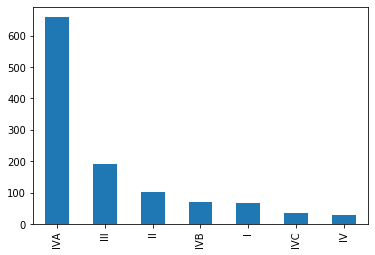

In [69]:
### make dataframes and join

df_stage=pd.DataFrame(data=data_stage,columns=['mrn','Stage'])
df_TNM=pd.DataFrame(data=data_TNM,columns=['mrn','TNM'])
df_stage.set_index('mrn')
df_stage.set_index('mrn')

print ('size of stage df:',df_stage.shape[0])
print ('size of tnm df:',df_TNM.shape[0])

df_merged=df_stage.merge(df_TNM,how='outer')
print ('size of merged df:',df_merged.shape[0])

def clean_Stage(stage):
    try:
        toReturn=stage.upper()
        toReturn=toReturn.split(' ')[1]
        #return toReturn
        try:
            pattern=r'I[ABC]|II[ABC]|III[ABC]'
            match=re.match(pattern,toReturn)
            search=re.search('I+',match.group())
            return search.group()
        except:
            return toReturn
    except:
        try:
            toReturn=stage.upper()
            return toReturn
        except:
            return stage
def getM_(stage):
    '''gets value for M from stage'''
    try:
        toReturn=stage.upper().split('M')[1]
        return toReturn
    except:
        return np.nan
df_merged['Stage']=df_merged['Stage'].apply(clean_Stage)
print(df_merged['Stage'].value_counts())
print(df_merged['Stage'].value_counts().plot(kind='bar'))
df_merged['T']=df_merged['TNM'].apply(getT)
df_merged['N']=df_merged['TNM'].apply(getN)
df_merged['M']=df_merged['TNM'].apply(getM_)

df_merged.to_csv('RM Staging.csv',index=False)


In [88]:
file='no_recur_mrns.csv'
df_val=pd.read_csv(file)
try:
    df_val['MRN']=df_val['MRN'].str.replace('-','')
    df_val['MRN']=df_val['MRN'].astype(int)
except:
    print('mrns already in correct form')
cols=['MRN','stage']
df_val=df_val[cols]
df_val.columns=['mrn','val_Stage']

stages=['I','II','III','IV','IVA','IVB','IVC']
df_val=df_val[df_val['val_Stage'].isin(stages)]

df_merged_=df_val.merge(df_merged,on='mrn',how='inner')
print (df_merged_)

from sklearn.metrics import cohen_kappa_score
df_merged_=df_merged_.dropna(subset=['Stage'])
cat_map={'I':1,'II':2,'III':3,'IVA':4,'IVB':5,'IVC':6}
score=cohen_kappa_score(df_merged_['val_Stage'].map(cat_map),df_merged_['Stage'].map(cat_map))
print ('cohen kappa:',score)

        mrn val_Stage Stage         TNM   T   N    M
0   2918770       IVA   IVA       T1N2    1   2  NaN
1   2929070       IVA   IVA   T1 N2c M0   1  2C    0
2   2950955       IVA   IVA      T3N2b    3  2B  NaN
3   2969796       IVA   III      T3N1M0   3   1    0
4   2549615       IVA   IVA   cT3N2b M0   3  2B    0
5   2973890       IVA   IVA    T2 N2b M   2  2B     
6   2975703       IVA   III       T3N1    3   1  NaN
7   1998538       IVA   IVA       T2N2    2   2  NaN
8   2991063       IVA   IVA   T4 N2C M0   4  2C    0
9   3010578       IVA   IVA      T3N2B    3  2B  NaN
10  3017233       IVA   IVA    T4aN2bM0  4A  2B    0
11  3018271       IVA   IVA      T3N2B    3  2B  NaN
12  3021006       IVA   IVA      T3N2b    3  2B  NaN
13  3043001       IVA   IVA      T1N2b    1  2B  NaN
14  3057972       IVA   IVA      T2N2B    2  2B  NaN
15  3055489       IVA   IVA      T2N2A    2  2A  NaN
16  3067976       IVA   IVA     T4 N2B    4  2B  NaN
17  2950899       IVA   IVA     T2N2cM0   2  2